# Exploration15 - 문자를 읽을 수 있는 딥러닝
사진 속 글씨를 읽을 수 있는 OCR 모델을 만들어보자.

---

### 루브릭 평가 기준

1. OCR을 활용하여 구현하려는 서비스 기획의 타당성 - 목표로하는 서비스가 OCR 적용이 가능하며, OCR을 활용했을 때 더욱 유용해지나
2. 명확하고 체계적인 모델 평가 기준 - 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었나
3. 평가 기준에 따른 충분한 분량의 테스트의 진행과 그 결과의 정리 - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었나

---

### 목차

0) 필요 모듈 import


1) 검증용 데이터셋
    

2) keras-ocr


3) Tesseract


4) Google OCR API


5) 결과 비교


6) 회고

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as img

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

from google.cloud import vision
import io

## 1.  검증용 데이터셋

In [2]:
img_folder = os.getcwd() + '/image'

images_path = glob.glob(img_folder + '/*.*')
images_path

['/aiffel/aiffel/exploration/ex15_ocr/image/roadsign4.png',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign6.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign18.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign13.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign17.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign7.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign16.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign2.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign15.png',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign12.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign1.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign20.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign14.jpeg',
 '/aiffel/aiffel/exploration/ex15_ocr/image/roadsign8.jpeg']

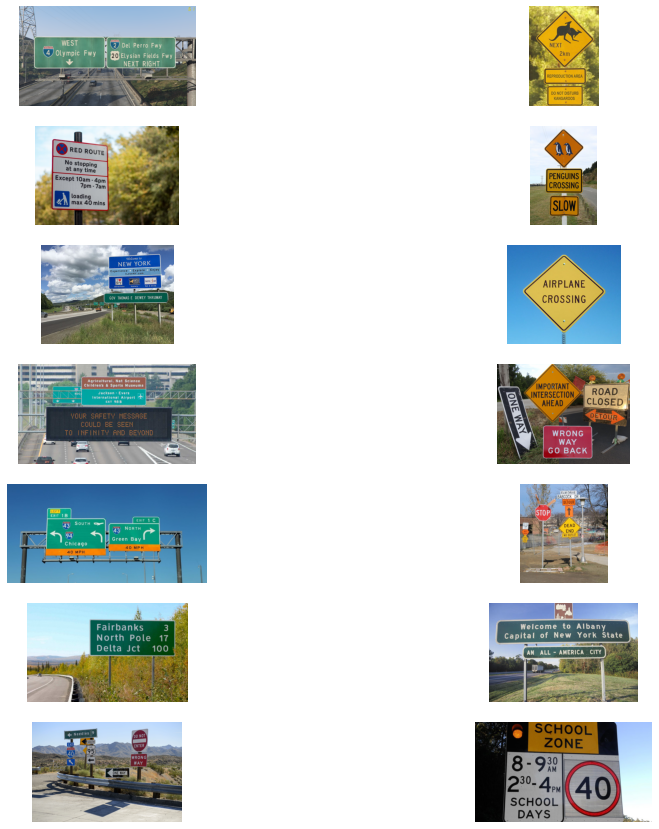

In [3]:
plt.figure(figsize=(15, 15))

for i, img_path in enumerate(images_path):
    plt.subplot(7, 2, i+1)
    image = img.imread(img_path)
    plt.imshow(image)
    plt.axis('off')

자율주행하는 자동차가 도로 위 표지판의 내용을 인식하는 것은 아주 중요한 문제라고 생각한다.  
그래서 도로 위 다양한 표지판의 글씨를 인식하는 것을 목표로 실습을 하고자 한다.    
교통 표지판은 글자 뿐만 아니라 속도나 거리 등을 나타내는 숫자 또한 포함하고 있으므로 문자와 숫자를 모두 잘 인식하는 모델을 찾아보자.

## 2. keras-ocr

In [4]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [ keras_ocr.tools.read(image) for image in images_path]
prediction_groups = [pipeline.recognize([image]) for image in images_path]

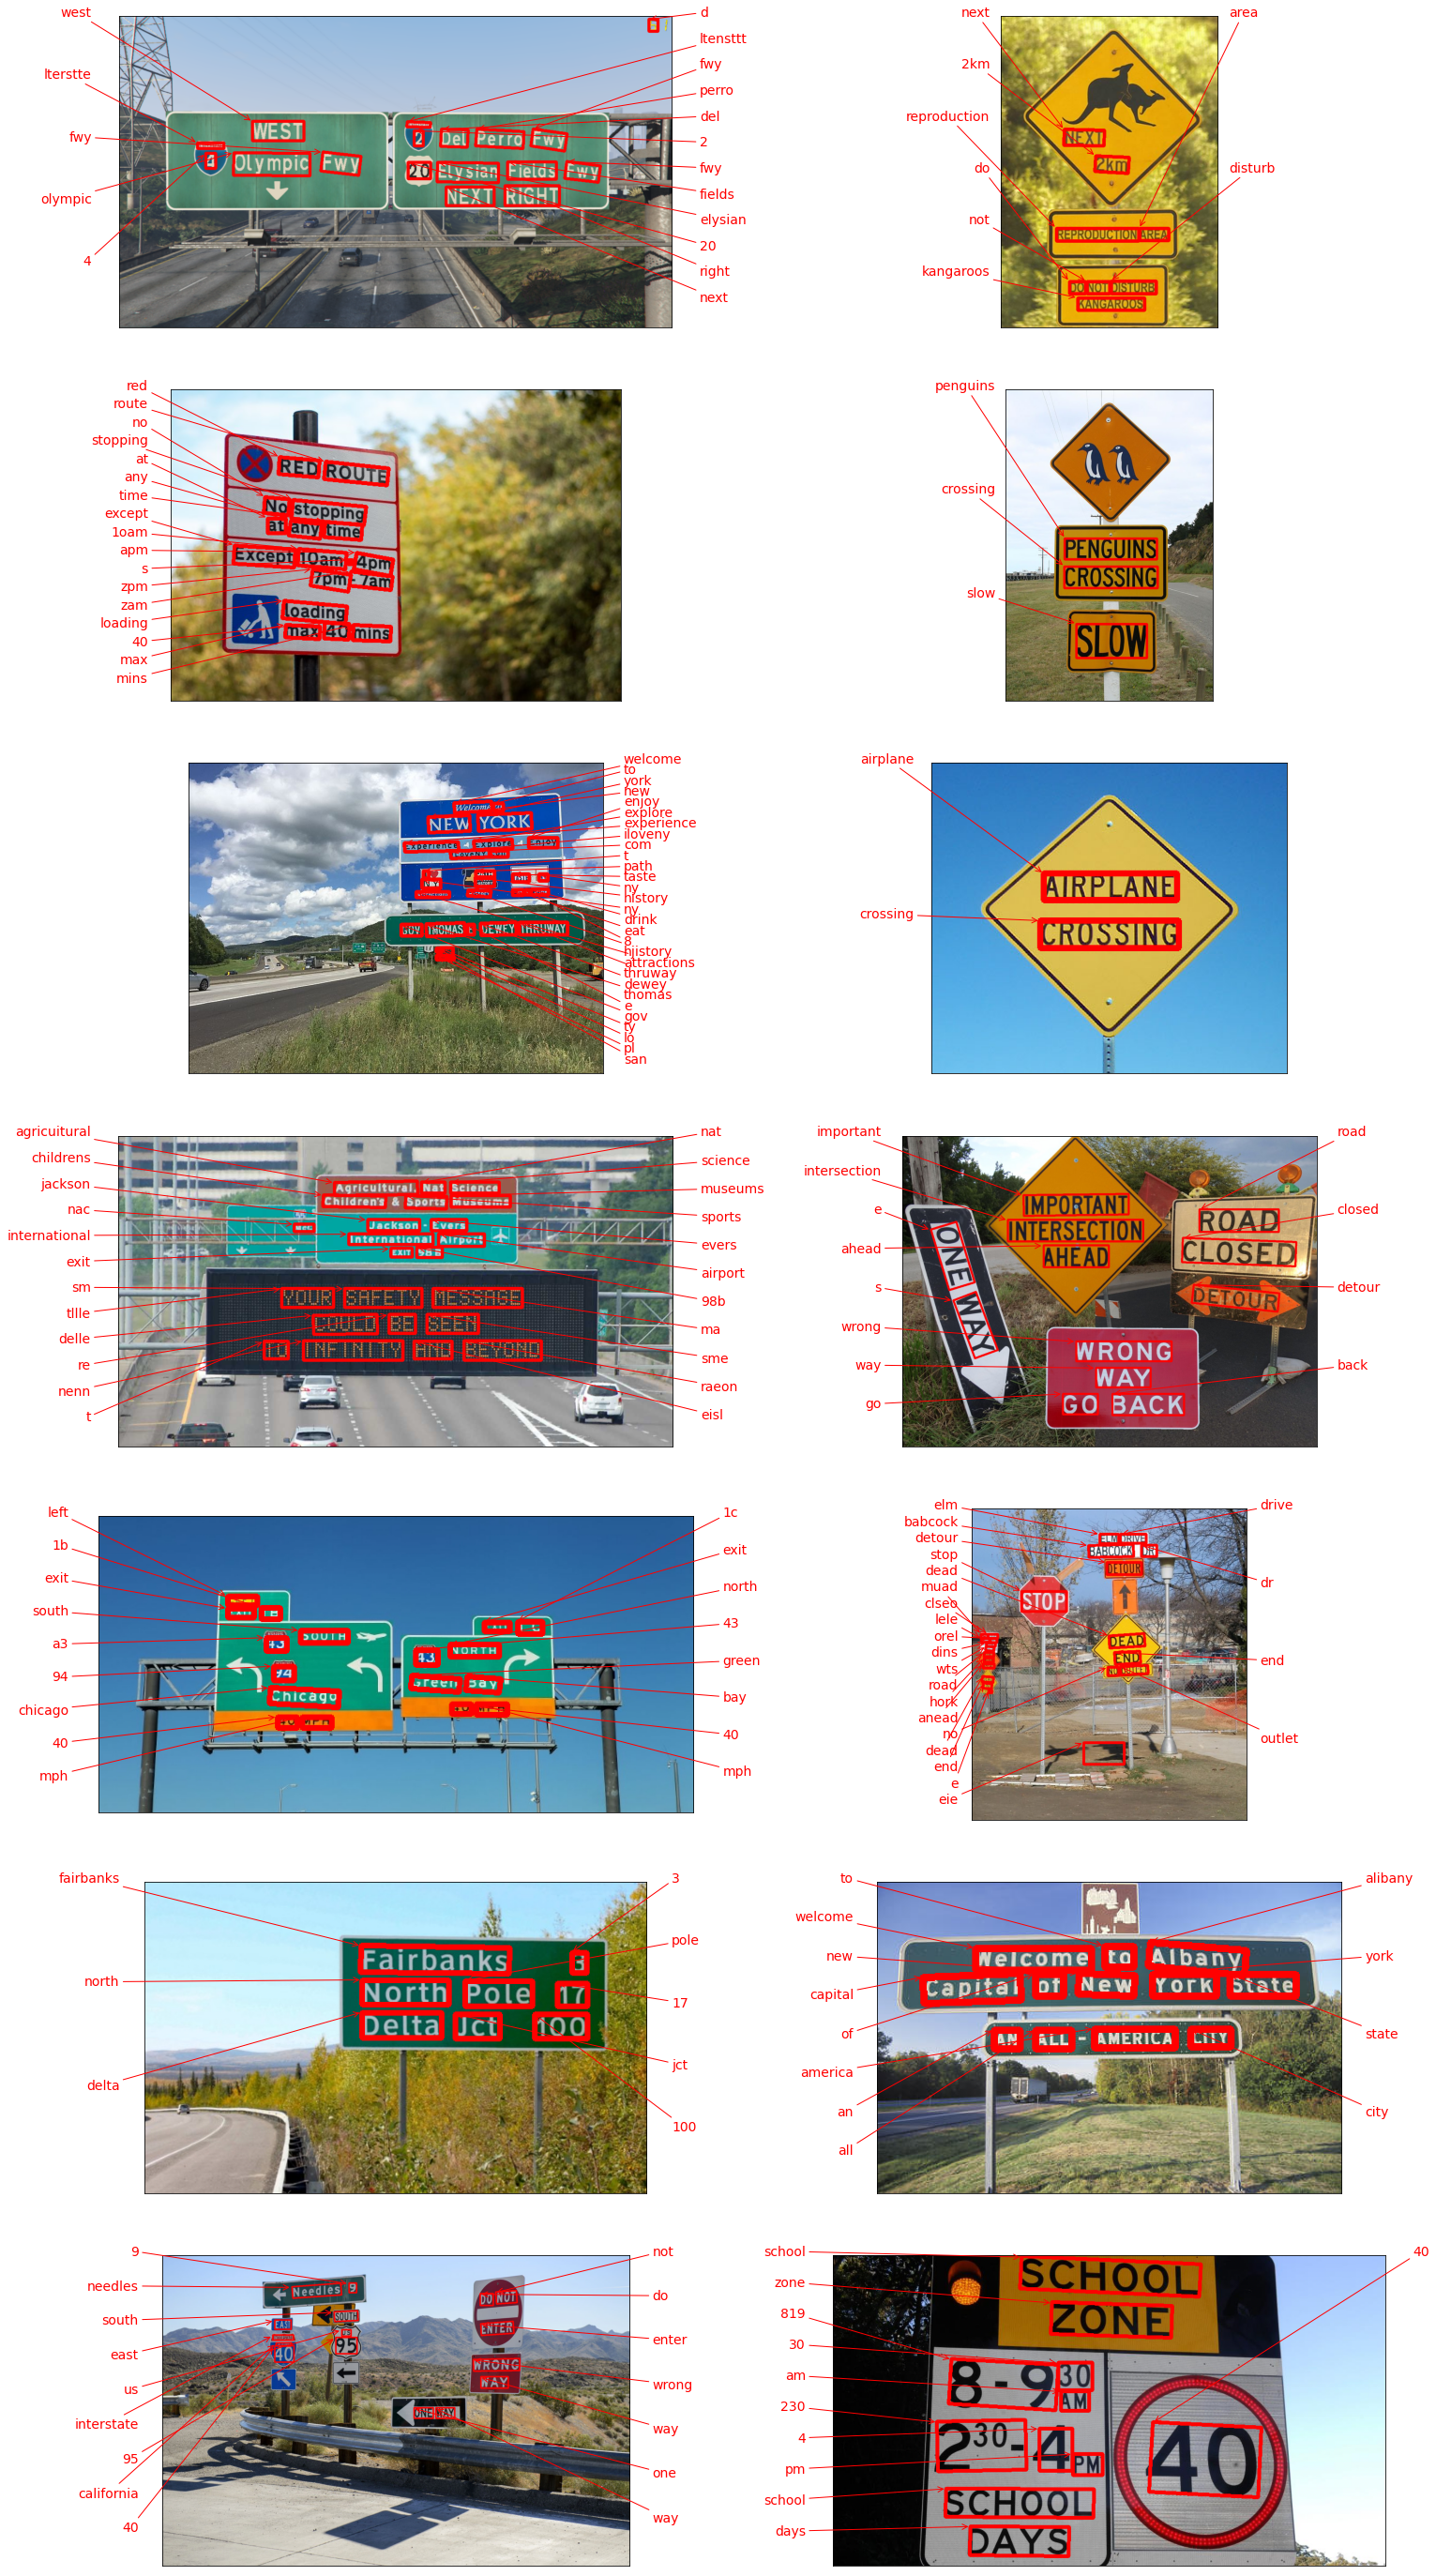

In [6]:
# Plot the predictions
fig, axs = plt.subplots(7, 2, figsize=(25, 50))

for i in range(len(axs)):
    for j in range(len(axs[i])):
        keras_ocr.tools.drawAnnotations(image=images[2*i+j], 
                                    predictions=prediction_groups[2*i+j][0], ax=axs[i,j])


대부분의 글자에 대해 높은 정확도로 인식하는 모습을 보이고 있다.

## 3. Tesseract

In [7]:
def crop_word_regions(image_path, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])

./output/cropped_img0/0000.png
./output/cropped_img0/0001.png
./output/cropped_img0/0002.png
./output/cropped_img0/0003.png
./output/cropped_img0/0004.png
./output/cropped_img0/0005.png
./output/cropped_img0/0006.png
./output/cropped_img0/0007.png
./output/cropped_img0/0008.png
./output/cropped_img0/0009.png
./output/cropped_img0/0010.png
./output/cropped_img0/0011.png
./output/cropped_img0/0012.png
./output/cropped_img0/0013.png
./output/cropped_img0/0014.png
./output/cropped_img0/0015.png
./output/cropped_img0/0016.png
./output/cropped_img0/0017.png
./output/cropped_img0/0018.png
./output/cropped_img0/0019.png
./output/cropped_img0/0020.png
./output/cropped_img0/0021.png
./output/cropped_img0/0022.png
./output/cropped_img0/0023.png
./output/cropped_img0/0024.png
./output/cropped_img0/0025.png


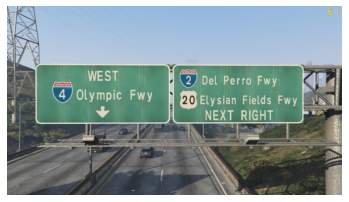



Wit

WEST

Oly mpic

i

The

=

ry

er


i

bY]

Perro

=

ni

Sar

Fields Fwy

NEX]

RIGHT



of


—

: i

------------------------------
./output/cropped_img1/0000.png
./output/cropped_img1/0001.png
./output/cropped_img1/0002.png
./output/cropped_img1/0003.png
./output/cropped_img1/0004.png
./output/cropped_img1/0005.png


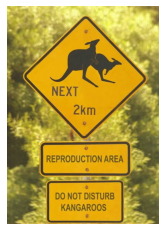

NO

NOT

DISTURB

KANGAROOS

¥


------------------------------
./output/cropped_img2/0000.png
./output/cropped_img2/0001.png
./output/cropped_img2/0002.png
./output/cropped_img2/0003.png
./output/cropped_img2/0004.png
./output/cropped_img2/0005.png
./output/cropped_img2/0006.png
./output/cropped_img2/0007.png
./output/cropped_img2/0008.png
./output/cropped_img2/0009.png
./output/cropped_img2/0010.png
./output/cropped_img2/0011.png
./output/cropped_img2/0012.png
./output/cropped_img2/0013.png
./output/cropped_img2/0014.png
./output/cropped_img2/0015.png
./output/cropped_img2/0016.png
./output/cropped_img2/0017.png
./output/cropped_img2/0018.png


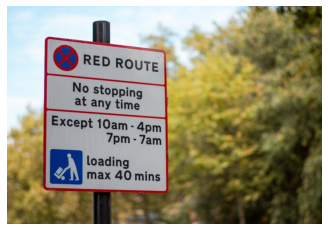


No

Stopping

at

any

time

Except

10am

|

4pm

7pm

—

Tam

C

loading

5.

max

40

mins

------------------------------
./output/cropped_img3/0000.png


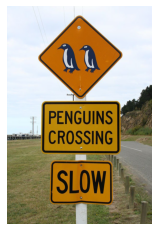


------------------------------
./output/cropped_img4/0000.png
./output/cropped_img4/0001.png
./output/cropped_img4/0002.png
./output/cropped_img4/0003.png
./output/cropped_img4/0004.png
./output/cropped_img4/0005.png
./output/cropped_img4/0006.png
./output/cropped_img4/0007.png
./output/cropped_img4/0008.png
./output/cropped_img4/0009.png


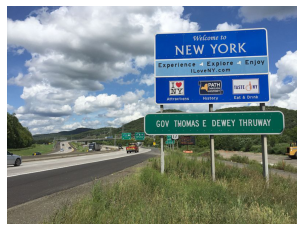

enc

Welcome to

ee NG aA

YORK

ATTTACTIONS

mistory

Fat & Urink

iy

!


------------------------------
./output/cropped_img5/0000.png
./output/cropped_img5/0001.png
./output/cropped_img5/0002.png


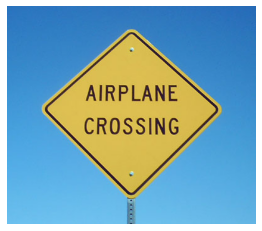

AIRPLANE

CROSSING

C S |

------------------------------
./output/cropped_img6/0000.png


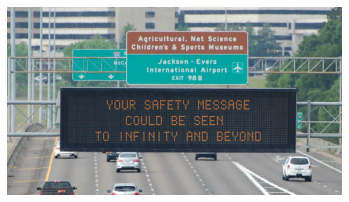


------------------------------
./output/cropped_img7/0000.png
./output/cropped_img7/0001.png
./output/cropped_img7/0002.png
./output/cropped_img7/0003.png
./output/cropped_img7/0004.png
./output/cropped_img7/0005.png
./output/cropped_img7/0006.png
./output/cropped_img7/0007.png


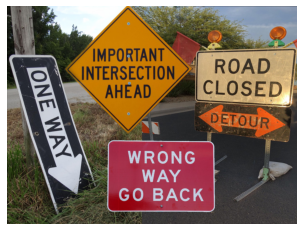

" ; a.


|

0 ie ‘ ; : ee - “pes 7 3 LNG 2 ARES EE IOP

“9


GO

BACK

------------------------------
./output/cropped_img8/0000.png
./output/cropped_img8/0001.png
./output/cropped_img8/0002.png
./output/cropped_img8/0003.png
./output/cropped_img8/0004.png
./output/cropped_img8/0005.png
./output/cropped_img8/0006.png
./output/cropped_img8/0007.png


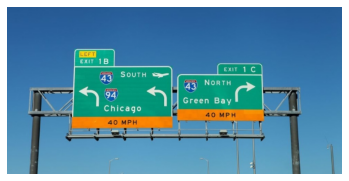

:

43)

SiS

‘

LUreen bay

re



------------------------------
./output/cropped_img9/0000.png
./output/cropped_img9/0001.png


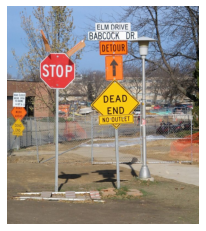



------------------------------
./output/cropped_img10/0000.png
./output/cropped_img10/0001.png
./output/cropped_img10/0002.png
./output/cropped_img10/0003.png
./output/cropped_img10/0004.png
./output/cropped_img10/0005.png
./output/cropped_img10/0006.png
./output/cropped_img10/0007.png
./output/cropped_img10/0008.png
./output/cropped_img10/0009.png


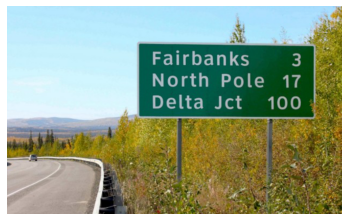

Fairbanks

3

Nortn

Tora.

1/

=

Detta

ICT

100

a 7 i: 7%

------------------------------
./output/cropped_img11/0000.png
./output/cropped_img11/0001.png
./output/cropped_img11/0002.png
./output/cropped_img11/0003.png
./output/cropped_img11/0004.png
./output/cropped_img11/0005.png
./output/cropped_img11/0006.png
./output/cropped_img11/0007.png
./output/cropped_img11/0008.png
./output/cropped_img11/0009.png
./output/cropped_img11/0010.png
./output/cropped_img11/0011.png
./output/cropped_img11/0012.png
./output/cropped_img11/0013.png
./output/cropped_img11/0014.png
./output/cropped_img11/0015.png
./output/cropped_img11/0016.png
./output/cropped_img11/0017.png


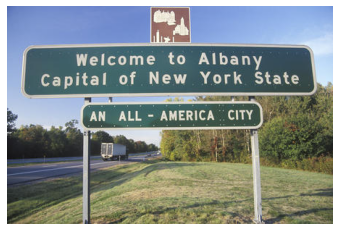

Sas a

Wweicome

a,

Capital

of

New

ache.

State

T

ae

=

—_

p

:

ALL - AMERICA

was

-


------------------------------
./output/cropped_img12/0000.png


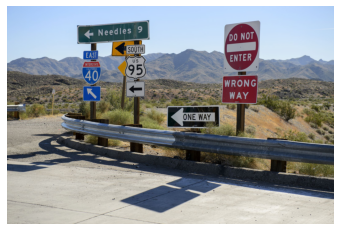


------------------------------
./output/cropped_img13/0000.png


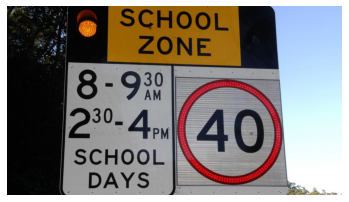


------------------------------


In [9]:
for i, img_path in enumerate(images_path):
    output_path = './output/cropped_img'+str(i)
    cropped_image_path_list = crop_word_regions(img_path, output_path)
    image = img.imread(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    recognize_images(cropped_image_path_list)
    print("-" * 30)

얼핏봐도 인식 결과가 좋아보이진 않는다.  
문자에 대한 인식도 잘 못하고 숫자 또한 제대로 인식하지 못하고 있다.  
이를 실제 서비스에 이용하기에는 많이 부족할 것 같다.

## 4. Google OCR API

In [10]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

#     vertices = (['({},{})'.format(vertex.x, vertex.y)
#                  for vertex in text.bounding_poly.vertices])

#     print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  './ethereal-fort-343012-61501dc52978.json'

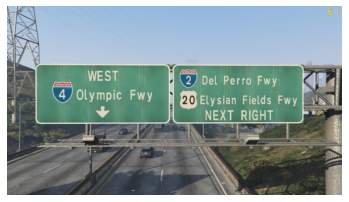

Texts:

"WEST
INTERSTATE
2 Del Perro Fwy
INTERSTATE
4 Olympic Fwy
20 Elysian Fields Fwy
NEXT RIGHT
"

"WEST"

"INTERSTATE"

"2"

"Del"

"Perro"

"Fwy"

"INTERSTATE"

"4"

"Olympic"

"Fwy"

"20"

"Elysian"

"Fields"

"Fwy"

"NEXT"

"RIGHT"


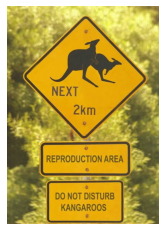

Texts:

"NEXT
2km
REPRODUCTION AREA
DO NOT DISTURB
KANGAROOS
"

"NEXT"

"2km"

"REPRODUCTION"

"AREA"

"DO"

"NOT"

"DISTURB"

"KANGAROOS"


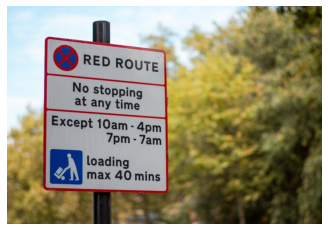

Texts:

"RED ROUTE
No stopping
at any time
Except 10am-4pm
7pm - 7am
loading
max 40 mins
"

"RED"

"ROUTE"

"No"

"stopping"

"at"

"any"

"time"

"Except"

"10am-4pm"

"7pm"

"-"

"7am"

"loading"

"max"

"40"

"mins"


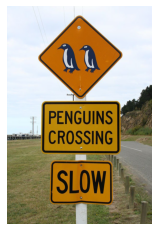

Texts:

"PENGUINS
CROSSING
SLOW
"

"PENGUINS"

"CROSSING"

"SLOW"


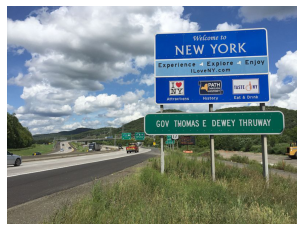

Texts:

"Welcome to
NEW YORK
Experience 4 Explore 4 Enjoy
ILoveNY.com
I
NY
PATH
TASTE
NY
THROUGH
HISTORY
Attractions
History
Eat & Drink
GOV THOMAS E DEWEY THRUWAY
IDAY
2PH-6AM
"

"Welcome"

"to"

"NEW"

"YORK"

"Experience"

"4"

"Explore"

"4"

"Enjoy"

"ILoveNY.com"

"I"

"NY"

"PATH"

"TASTE"

"NY"

"THROUGH"

"HISTORY"

"Attractions"

"History"

"Eat"

"&"

"Drink"

"GOV"

"THOMAS"

"E"

"DEWEY"

"THRUWAY"

"IDAY"

"2PH-6AM"


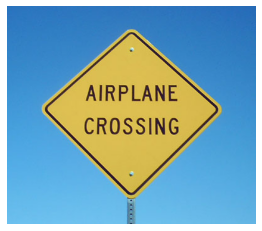

Texts:

"AIRPLANE
CROSSING
"

"AIRPLANE"

"CROSSING"


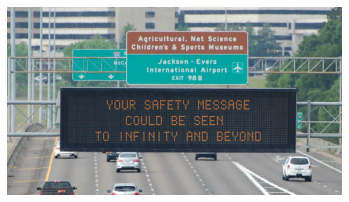

Texts:

"Agricultural, Nat Science
Children's & Sports Museums
Jackson - Evers
International Airport
EXIT 98 B
YOUR SAFETY MESSAGE
COULD BE SEEN
TO
INFINITY AND BEYOND
"

"Agricultural,"

"Nat"

"Science"

"Children's"

"&"

"Sports"

"Museums"

"Jackson"

"-"

"Evers"

"International"

"Airport"

"EXIT"

"98"

"B"

"YOUR"

"SAFETY"

"MESSAGE"

"COULD"

"BE"

"SEEN"

"TO"

"INFINITY"

"AND"

"BEYOND"


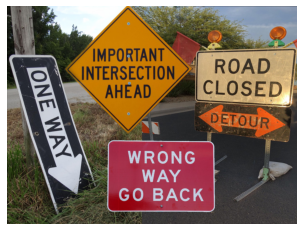

Texts:

"IMPORTANT
INTERSECTION
AHEAD
ROAD
CLOSED
DETOUR
WRONG
WAY
GO BACK
ONE WAY
"

"IMPORTANT"

"INTERSECTION"

"AHEAD"

"ROAD"

"CLOSED"

"DETOUR"

"WRONG"

"WAY"

"GO"

"BACK"

"ONE"

"WAY"


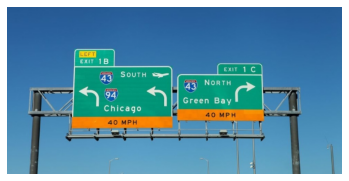

Texts:

"LEFT
EXIT 1B
EXIT 1 C
SOUTH
43
NORTH
43
94
Green Bay
Chicago
40 MPH
40 MPH
"

"LEFT"

"EXIT"

"1B"

"EXIT"

"1"

"C"

"SOUTH"

"43"

"NORTH"

"43"

"94"

"Green"

"Bay"

"Chicago"

"40"

"MPH"

"40"

"MPH"


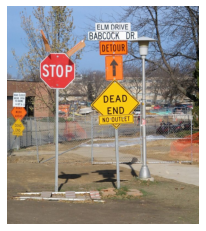

Texts:

"ELM DRIVE
ВАВСОСК
BABCOCK DR.
DETOUR
STOP
ROAD CLOSED
AHEAD. OPEN
TO DORMS
& LOT 34
DEAD
ROAD
WORK
AHEAD
END
NO OUTLET
DEAD
END
NO-0UTLET
"

"ELM"

"DRIVE"

"ВАВСОСК"

"BABCOCK"

"DR."

"DETOUR"

"STOP"

"ROAD"

"CLOSED"

"AHEAD."

"OPEN"

"TO"

"DORMS"

"&"

"LOT"

"34"

"DEAD"

"ROAD"

"WORK"

"AHEAD"

"END"

"NO"

"OUTLET"

"DEAD"

"END"

"NO-0UTLET"


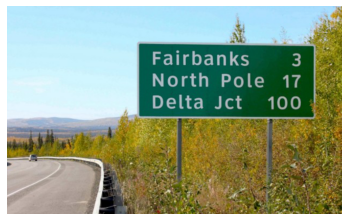

Texts:

"Fairbanks
North Pole 17
3
Delta Jct 100
"

"Fairbanks"

"North"

"Pole"

"17"

"3"

"Delta"

"Jct"

"100"


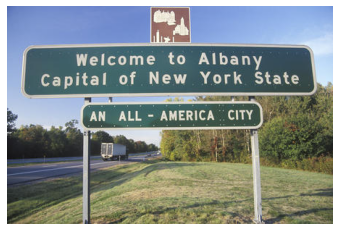

Texts:

"Welcome to Albany
Capital of New York State
AN ALL - AMERICA CITY
"

"Welcome"

"to"

"Albany"

"Capital"

"of"

"New"

"York"

"State"

"AN"

"ALL"

"-"

"AMERICA"

"CITY"


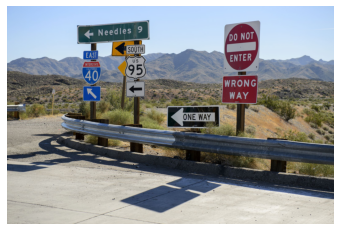

Texts:

"Needles 9
DO NOT
SOUTH
EAST
ENTER
US
INTERSTATE
95
CALIFORNIA
40
WRONG
我法。
WAY
ONE WAY
"

"Needles"

"9"

"DO"

"NOT"

"SOUTH"

"EAST"

"ENTER"

"US"

"INTERSTATE"

"95"

"CALIFORNIA"

"40"

"WRONG"

"我"

"法"

"。"

"WAY"

"ONE"

"WAY"


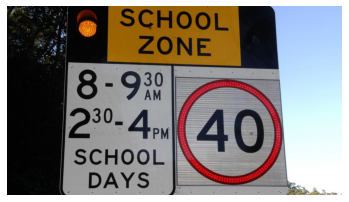

Texts:

"SCHOOL
ZONE
8-9 AM
30
230-440
SCHOOL
DAYS
"

"SCHOOL"

"ZONE"

"8-9"

"AM"

"30"

"230-440"

"SCHOOL"

"DAYS"


In [12]:
for img_path in images_path:
    image = img.imread(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    detect_text(img_path)

대소문자를 구분하고 숫자에 대해서도 높은 정확도를 보이고 있다.  
다만, 글자가 아닌 부분에 대해서 글자로 인식하거나 영어뿐인 사진에서 한자를 인식하는 등 과도하게 텍스트를 검출하는 경향이 보인다.  

## 5. 결과 비교

숫자와 글자가 적당히 섞인 이미지를 이용해 세 가지 방식으로 텍스트를 인식한 결과를 비교해 보자.

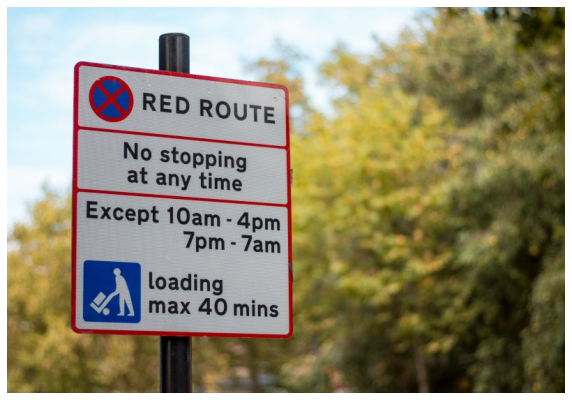

In [13]:
test_img_path = images_path[2]

image = img.imread(test_img_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

<keras-ocr>


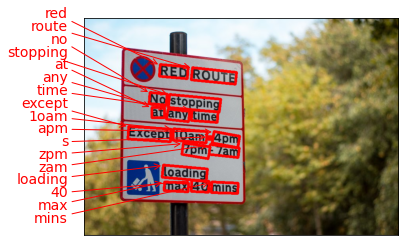

<Tesseract>
./output/test/0000.png
./output/test/0001.png
./output/test/0002.png
./output/test/0003.png
./output/test/0004.png
./output/test/0005.png
./output/test/0006.png
./output/test/0007.png
./output/test/0008.png
./output/test/0009.png
./output/test/0010.png
./output/test/0011.png
./output/test/0012.png
./output/test/0013.png
./output/test/0014.png
./output/test/0015.png
./output/test/0016.png
./output/test/0017.png
./output/test/0018.png

No

Stopping

at

any

time

Except

10am

|

4pm

7pm

—

Tam

C

loading

5.

max

40

mins

<Google OCR API>
Texts:

"RED ROUTE
No stopping
at any time
Except 10am-4pm
7pm - 7am
loading
max 40 mins
"

"RED"

"ROUTE"

"No"

"stopping"

"at"

"any"

"time"

"Except"

"10am-4pm"

"7pm"

"-"

"7am"

"loading"

"max"

"40"

"mins"


In [14]:
print("<keras-ocr>")
keras_ocr.tools.drawAnnotations(image=images[2], predictions=prediction_groups[2][0])
plt.show()

print("<Tesseract>")
output_path = './output/test'
cropped_image_path_list = crop_word_regions(test_img_path, output_path)
recognize_images(cropped_image_path_list)

print("<Google OCR API>")
detect_text(test_img_path)

keras-ocr : 문자(영어)에 대한 정확도는 상당히 높아 보임, 다만 시간 표기와 같이 숫자와 알파벳이 연결되어있는 경우 숫자에 대한 인식률이 떨어짐  
tesseract : 텍스트 자체를 인식하지 못하는 부분이 있음, 숫자를 인식하기도 하지만 그 외 전체적인 정확도가 다른 모델에 비해 많이 낮음, 다양한 언어를 지원하지만 정확도가 의심스러움  
Google OCR : 매우 높은 정확도를 보이고 있음, 실제 서비스에 사용한다면 이를 이용하는 것이 가장 좋은 선택일 것 같음


## 6. 회고

#### - bounding box 그리기

tesseract와 google ocr에 대해서도 keras-ocr 처럼 바운딩 박스를 그리고 싶었으나 아직 api 사용이 미숙하여 하지 못했다.  
이번 프로젝트에서 가장 아쉬웠던 점이다.  



#### - 신기하다!!

ocr 기능은 학교 다닐 때 pdf 수업 자료 내에서 검색할 때만 사용을 해봤는데 이렇게 사진에서도 텍스트를 검출하는 것을 보니 정말 신기하다.  
요즘 스마트폰에서 사진만 찍으면 전화번호를 인식해주고 글씨를 인식해 검색해주는 기능이 다 이런식으로 구현이 된것인가? 하는 궁금증이 생겼다.  
그렇다면 나도 실제 서비스에 쓰일 수 있는 모델을 언젠가는...?!
